In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import albumentations as A
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import cv2

In [65]:
# dataset, dataset_info = tfds.load(
#     "malaria", with_info=True, split=['train[:80%]','train[80%:90%]','train[90%:]'], shuffle_files=True
#     )
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, shuffle_files=True
    )

In [66]:
dataset

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [67]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [68]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [69]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_ds, val_ds, test_ds = split(dataset["train"], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [70]:
print(len(train_ds))
print(len(val_ds))
print( len(test_ds))

22046
2755
2757


In [71]:
def get_label_str(label):
  return "Parasitized" if label == 0 else "Uninfected"

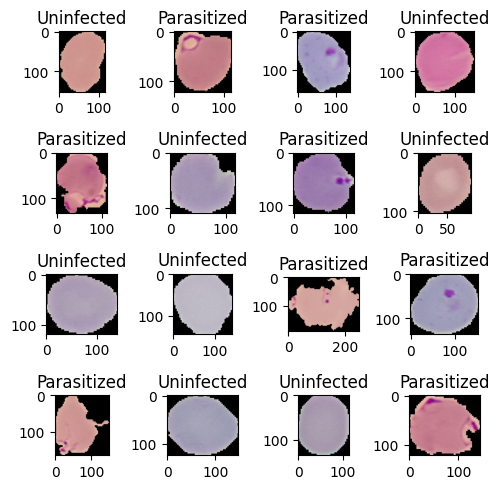

In [72]:
fig = plt.figure(figsize=(5, 5))
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))
  plt.tight_layout()

In [73]:
IM_size = 224
BATCH_SIZE = 32

In [100]:
@tf.function
def resize_rescale(inputs):
  print("Hi Here")
  tf.print("Graph mode Print")
  return tf.image.resize(inputs['image'], (IM_size, IM_size))/255., inputs['label']

In [99]:
tf.config.run_functions_eagerly(True)
_,_ = resize_rescale(inputs)
_,_ = resize_rescale(inputs)
_,_ = resize_rescale(inputs)
_,_ = resize_rescale(inputs)

NameError: name 'inputs' is not defined

In [92]:
@tf.function
def augment(inputs):
  image, label = resize_rescale(inputs)
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  # image = tf.image.adjust_saturation(image, saturation_factor=0.3) not good for this dataset
  # image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  # image = tf.image.flip_left_right(image)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [93]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

    @tf.function
    def call(slef, img):
      return tf.image.rot90(img)

In [77]:
resizing_rescale_layer = tf.keras.Sequential([
    Resizing(IM_size, IM_size),
    Rescaling(1./255.)
])

In [94]:
# augment_layers = tf.keras.Sequential([
#     RandomRotation(factor=(0.25, 0.251)),
#     RandomFlip(mode='horizontal'),
# ])

augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal'),
])

@tf.function
def augment_layer(input):
  return augment_layers(resizing_rescale_layer(input["image"]), training=True), input["label"]

In [79]:
# train_dataset = train_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = train_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

In [80]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [81]:
original_image, label = next(iter(val_dataset))
original_image = original_image[0]

# augmented_img = tf.image.flip_left_right(original_image)
# augmented_img = tf.image.random_flip_up_down(original_image)
# augmented_img = tf.image.rot90(original_image)
# augmented_img = tf.image.adjust_brightness(original_image, delta=0.6)
# augmented_img = tf.image.random_saturation(original_image, lower=2, upper=12)
# augmented_img = tf.image.central_crop(original_image, central_fraction=0.8)
augmented_img = tf.image.adjust_saturation(original_image, saturation_factor=0.3)

AttributeError: image dtype must be either floating point or integer

In [ ]:
visualize(original_image, augmented_img)

In [ ]:
for img, label in train_dataset.take(1):
  print(img, label)

In [ ]:
image_1 = cv2.resize(cv2.imread('/content/cat.jfif'), (IM_size, IM_size))
label_1 = 0
image_2 = cv2.resize(cv2.imread('/content/dog.jfif'), (IM_size, IM_size))
label_2 = 1

lamda = tfp.distributions.Beta(0.2, 0.2)
lamda = lamda.sample(1)[0].numpy()
print(image_1.shape, image_2.shape)

image = lamda*image_1 + (1-lamda)*image_2
label = lamda*label_1 + (1-lamda)*label_2
print(image.shape, label)

plt.imshow(image/255)

In [ ]:
train_dataset_1  = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)
train_dataset_2  = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)

  return image, label


In [ ]:
train_dataset_mixup = mixed_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(mixup).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_mixup

In [ ]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(1,7,1)
image_1 = cv2.resize(cv2.imread('/content/cat.jfif'), (IM_size, IM_size))
plt.imshow(image_1)

plt.subplot(1,7,2)
image_2 = cv2.resize(cv2.imread('/content/dog.jfif'), (IM_size, IM_size))
plt.imshow(image_2)

plt.subplot(1,7,3)
crop_dog = tf.image.crop_to_bounding_box(image_2, 20, 100, 100, 98)
plt.imshow(crop_dog)

plt.subplot(1,7,4)
image_3 = tf.image.pad_to_bounding_box(crop_dog, 20, 100, IM_size,IM_size)
plt.imshow(image_3)

plt.subplot(1,7,5)
image_3 = tf.image.pad_to_bounding_box(crop_dog, 20, 100, IM_size,IM_size)
plt.imshow(image_3 + image_1)

plt.subplot(1,7,6)
crop_cat = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)
plt.imshow(crop_cat)

plt.subplot(1,7,7)
image_4 = tf.image.pad_to_bounding_box(crop_cat, 20, 100, IM_size,IM_size)
plt.imshow(image_1 - image_4 + image_3)

In [ ]:
def box(lamda):
  r_x =  tf.cast(tfp.distributions.Uniform(0,IM_size).sample(1)[0], dtype= tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0,IM_size).sample(1)[0], dtype= tf.int32)

  r_w = tf.cast(IM_size*tf.math.sqrt(1-lamda), dtype=tf.int32)
  r_h = tf.cast(IM_size*tf.math.sqrt(1-lamda), dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_size)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_size)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_size)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_size)

  r_w = y_b_r - r_y
  if (r_w == 0):
    r_w = 1
  r_h = x_b_r - r_x
  if (r_h == 0):
    r_h = 1

  return r_x, r_y, r_w, r_h

In [ ]:
def cut_mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2= tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_size,IM_size)
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_size,IM_size)

  image = image_1 - pad_1 + pad_2

  lamda = 1 - (r_h*r_w)/(IM_size*IM_size)
  label = lamda*tf.cast(label_1, dtype=tf.float64) + (1-lamda)*tf.cast(label_2, dtype=tf.float64)

  return image, label

In [ ]:
train_dataset_cut_mixup = mixed_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(cut_mixup).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_cut_mixup

In [ ]:
transforms = A.Compose([
    A.Resize(IM_size, IM_size),
    A.OneOf([A.HorizontalFlip(), A.VerticalFlip()], p=0.3),
    A.RandomRotate90(),
    # A.RandomGridShuffle(),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
    A.Cutout()
    # A.Sharpen(alpha=(0.2, 0.5), lightness_min=(0.5,1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)

  return image

In [ ]:
def process_data(image, label):
  aug_img = tf.numpy_function(aug_albument, [image], tf.float32)

  return aug_img, label

In [ ]:
train_dataset_albument = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(process_data).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_albument

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model = Model(inputs = [func_input], outputs = [func_output])

lenet_model.summary()

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(inputs = [func_input], outputs = [output])

feature_extractor_model.summary()

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2)
])

feature_extractor_seq_model.summary()

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_extractor_seq_model(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides = 2*strides)
    self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_subclass = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape=(IM_size, IM_size, 3))
x = feature_subclass(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenet_model_func = Model(inputs = [func_input], outputs = [func_output])

lenet_model_func.summary()


In [ ]:
class LenetModel(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_subclass = LenetModel(8, 3, 1, "valid", "relu", 2)
lenet_subclass(tf.zeros([1, 224, 224, 3])) # for building summary of model
lenet_subclass.summary()

In [ ]:
class CustomDense(Layer):
  def __init__(self, output_units, activation):
    super(CustomDense, self).__init__()

    self.output_units = output_units
    self.activation = activation

    def build(self, input_feature_shape):
      self.weights = self.add_weight((input_feature_shape[-1], self.output_units), initializer="random_normal", trainable=True)
      self.bias = self.add_weight((self.output_units,), initializer="random_normal",  trainable=True)

    def call(self, input_features):
      if(self.activation == "relu"):
        return tf.nn.relu(tf.matmul(input_features, self.weights) + self.bias)
      elif( self.activation == "sigmoid"):
        return tf.math.sigmoid(tf.matmul(input_features, self.weights) + self.bias)
      else:
        return tf.matmul(input_features, self.weights) + self.bias


In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_size, IM_size, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    CustomDense(100, activation = 'relu'),
    BatchNormalization(),
    CustomDense(10, activation = 'relu'),
    BatchNormalization(),
    CustomDense(1, activation = 'sigmoid')
])

lenet_custom_model.summary()

In [ ]:
dropout_rate = 0.3
model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resizing_rescale_layer,
    augment_layers,
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    Dense(10, activation = 'relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

model.summary()

In [ ]:

class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n Epoch Number {} has a loss of {}".format(epoch+1,logs["loss"]))

  def on_batch_end(self,batch, logs):
    print("\n Batch Number {} has a loss of {}".format(batch+1,logs["loss"]))

In [ ]:
csv_callback = CSVLogger('logs.csv', separator=',', append=False)

In [ ]:
es_callback =  EarlyStopping(monitor="val_loss", min_delta=0, patience=2, verbose=1, mode="auto", baseline=None, restore_best_weights=False)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
checkpoint_callback = ModelCheckpoint("checkpoints/", monitor='val_loss', verbose=0, save_best_only=True, mode='auto', save_weights_only=False, save_freq='epoch')

In [ ]:
platue_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

In [ ]:
metrics = [TruePositives(name="TP"), FalsePositives(name="FP"), TrueNegatives(name="TN"), FalseNegatives(name="FN"),
            BinaryAccuracy(name="accuracy"),Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]

In [ ]:
# def custom_bce(y_true, y_pred):
#   bce = BinaryCrossentropy()
#   return bce(y_true, y_pred)

FACTOR = 1
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * FACTOR

  return loss

In [ ]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR

  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * self.FACTOR

In [ ]:
# def custom_accuracy(y_true, y_pred):
#   return binary_accuracy(y_true, y_pred)

FACTOR = 1
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred) * FACTOR

  return metric

In [89]:
FACTOR = 1
class CustomAccurcy(tf.keras.metrics.Metric):
  def __init__(self, name="CUSTOM_ACCURACY", FACTOR=1):
    super(CustomAccurcy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name=name, initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype=tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

In [90]:
# lenet_model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=metrics, run_eagerly=True)
lenet_model.compile(optimizer=Adam(learning_rate=0.01), loss=CustomBCE(FACTOR), metrics=CustomAccurcy())

In [ ]:
history = lenet_model.fit(train_dataset, epochs=2, verbose=1, validation_data=val_dataset, callbacks=[platue_callback])

Epoch 1/2


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_1". You passed a data dictionary with keys ['image', 'label']. Expected the following keys: ['input_1']


In [2]:
Optimizer=Adam(learning_rate=0.01)
epochs = 3
Metric= BinaryAccuracy()
Metric_Val = BinaryAccuracy()

NameError: name 'Adam' is not defined

In [1]:
Optimizer=Adam(learning_rate=0.01)
epochs = 3
Metric= BinaryAccuracy()
Metric_Val = BinaryAccuracy()

for epoch in range(epochs):
  print("Training start for epoch number {}".format(epoch))
  for step, (x_batch, y_batch) in enumerate(train_dataset):

    with tf.GradientTape() as recorder:
      y_pred =  model(x_batch, training=True)
      loss = custom_bce(y_batch, y_pred)

    partial_derivatives = recorder.graident(loss, model.trainable_weights)

    Optimizer.apply_gradients(zip(partial_derivatives, model.trainable_weights))

    Metric.update_state(y_batch, y_pred)

  print("Training loss",loss)

  print("The trainig accuracy is",Metric.result())
  Metric.reset_states()

  for (x_batch_val, y_batch_val) in val_dataset:
    y_pred_val =  model(x_batch_val, training=False)
    loss_val = custom_bce(y_batch_val, y_pred_val)

    Metric_Val.update_state(y_batch_val, y_pred_val)

  print("Validation loss", loss_val)
  print("The val accuracy is",Metric_Val.result())
  Metric_Val.reset_states()

NameError: name 'Adam' is not defined

In [3]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred =  model(x_batch, training=True)
      loss = custom_bce(y_batch, y_pred)

  partial_derivatives = recorder.graident(loss, model.trainable_weights)

  Optimizer.apply_gradients(zip(partial_derivatives, model.trainable_weights))

  Metric.update_state(y_batch, y_pred)

  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
  y_pred_val =  model(x_batch_val, training=False)
  loss_val = custom_bce(y_batch_val, y_pred_val)

  Metric_Val.update_state(y_batch_val, y_pred_val)

  return loss_val

NameError: name 'tf' is not defined

In [ ]:
for epoch in range(epochs):
  print("Training start for epoch number {}".format(epoch))
  for step, (x_batch, y_batch) in enumerate(train_dataset):
    loss = training_block(x_batch, y_batch)


  print("Training loss",loss)

  print("The trainig accuracy is",Metric.result())
  Metric.reset_states()

  for (x_batch_val, y_batch_val) in val_dataset:
    loss_val = val_block(x_batch_val, y_batch_val)

  print("Validation loss", loss_val)
  print("The val accuracy is",Metric_Val.result())
  Metric_Val.reset_states()

In [ ]:
def model_learn(model, loss_function, Metric, Metric_Val, Optimizer, train_dataset, val_dataset, epochs):
  for epoch in range(epochs):
    print("Training start for epoch number {}".format(epoch))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)


    print("Training loss",loss)

    print("The trainig accuracy is",Metric.result())
    Metric.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("Validation loss", loss_val)
    print("The val accuracy is",Metric_Val.result())
    Metric_Val.reset_states()

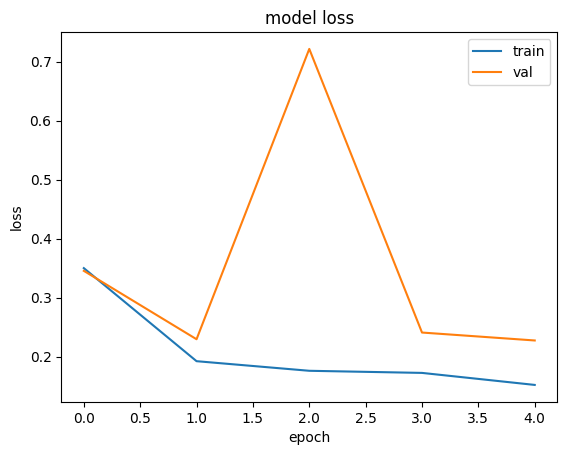

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

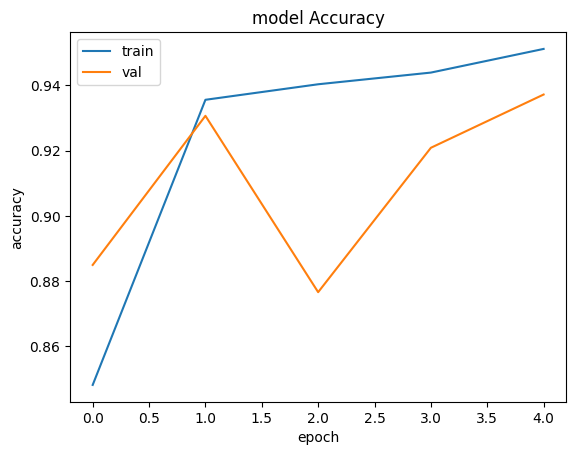

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 17s 34ms/step - loss: 0.2524 - TP: 1339.0000 - FP: 166.0000 - TN: 1224.0000 - FN: 28.0000 - accuracy: 0.9296 - precision: 0.8897 - recall: 0.9795 - auc: 0.9734


[0.2524398863315582,
 1339.0,
 166.0,
 1224.0,
 28.0,
 0.9296336770057678,
 0.8897010087966919,
 0.9795171618461609,
 0.9734396934509277]

In [ ]:
def parasite_or_not(x):
  if x < 0.5:
    return str("P")
  else:
    return str("U")

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 19s 19s/step


'U'

1/1 [==============================] - 0s 26ms/step


<ipython-input-76-0a049fd7d1a8>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,3, i+1)


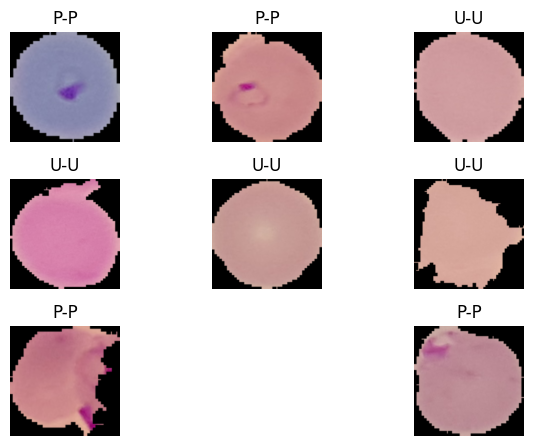

In [ ]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i]) + "-" + parasite_or_not(lenet_model.predict(image)[i][0]))
    plt.tight_layout()
    plt.axis('off')

In [ ]:
labels = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)

In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0
 1 1 1 0 0 1 0 1 1 0 1 0 0]


In [ ]:
predicted  = lenet_model.predict(test_dataset)
print(predicted.shape)
print(predicted[:,0].shape)

(2757, 1)
(2757,)


In [ ]:
thresh_hold = 0.5
cm = confusion_matrix(labels, predicted[:,0] > thresh_hold)
print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix - {}" .format(thresh_hold))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [87, 2757]

In [ ]:
fp, tp, thresholds =  roc_curve(labels, predicted[:,0])

plt.plot(fp, tp)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

skip = 20
for i in range(0, len(thresholds), skip)
  plt.text(fp[i],tp[i],thresholds[i])

plt.grid()
plt.show()